<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/CorrGrodU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from matplotlib import pyplot as plt
from scipy.interpolate import PchipInterpolator

# **Fish!**


**For this project I decided to use a data set I had used for a previous project. This data set containted the recorded length and mass of a few thousand trout at Rocky Mountain National Park. When I was first working with this data I noticed there was a pretty clear trend between the mass of the length of trout. This seemed like something that would be cool to model, and to some extent useful information.**

In [57]:
#Import data
trout_dataRaw = pd.read_csv('https://irma.nps.gov/DataStore/DownloadFile/705171?Reference=2304495')
#Remove rows without a length or mass value
trout_dataM = trout_dataRaw.query('mass >= 0')
trout_dataL = trout_dataM.query('length >= 0')
trout_data = trout_dataL
trout_data

,occurrenceID,eventID,basisOfRecord,taxonID,scientificName,recordedBy,individualCount,organismQuantity,organismQuantityType,occurrenceStatus,publicDisplay,dataAccess,pass,length,mass,geneticsSampled,occurrenceRemarks
0,NIN-2021-001,NIN-2021,HumanObservation,BRK,"Salvelinus fontinalis (Mitchill, 1814)","YK,DP,LF",1,1,individuals,present,yes,unrestricted,1,151.0,31.00,Y,NaN
1,NIN-2021-002,NIN-2021,HumanObservation,BRK,"Salvelinus fontinalis (Mitchill, 1814)","YK,DP,LF",1,1,individuals,present,yes,unrestricted,1,69.0,2.50,Y,NaN
2,NIN-2021-003,NIN-2021,HumanObservation,BRK,"Salvelinus fontinalis (Mitchill, 1814)","YK,DP,LF",1,1,individuals,present,yes,unrestricted,1,55.0,2.00,N,NaN
3,NIN-2021-004,NIN-2021,HumanObservation,BRK,"Salvelinus fontinalis (Mitchill, 1814)","YK,DP,LF",1,1,individuals,present,yes,unrestricted,1,57.0,1.75,N,NaN
4,NIN-2021-005,NIN-2021,HumanObservation,BRK,"Salvelinus fontinalis (Mitchill, 1814)","YK,DP,LF",1,1,individuals,present,yes,unrestricted,1,53.0,1.25,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,BT3-2022-004,BT3-2022,HumanObservation,CRT,"Oncorhynchus clarkii (Richardson, 1836)","FC, LF, ES, LQ, SR, JR",1,1,individuals,present,yes,unrestricted,1,120.0,16.50,N,NaN
1516,BT3-2022-005,BT3-2022,HumanObservation,CRT,"Oncorhynchus clarkii (Richardson, 1836)","FC, LF, ES, LQ, SR, JR",1,1,individuals,present,yes,unrestricted,1,125.0,17.00,N,NaN
1517,BT3-2022-006,BT3-2022,HumanObservation,CRT,"Oncorhynchus clarkii (Richardson, 1836)","FC, LF, ES, LQ, SR, JR",1,1,individuals,present,yes,unrestricted,1,224.0,105.00,N,NaN
1518,BT3-2022-007,BT3-2022,HumanObservation,CRT,"Oncorhynchus clarkii (Richardson, 1836)","FC, LF, ES, LQ, SR, JR",1,1,individuals,present,yes,unrestricted,1,185.0,62.00,N,NaN


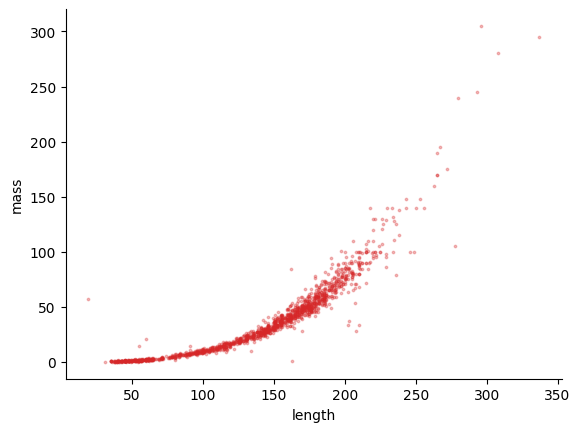

In [58]:
#Plot the data
trout_data.plot(kind='scatter', x='length', y='mass', s=3, alpha=.3, c="C3")
plt.gca().spines[['top', 'right',]].set_visible(False)

**The data seems to follow a very disinct trend, which looked closest to an exponential curve.**

**For my first model I used the same likelihood we used in class, and tweaked the parameters till it ran.**

In [75]:
with pm.Model() as model_trout:

    #Priors for the linear part
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=20)
    σ = pm.HalfCauchy("σ", 10)

    #Covert to deterministic, and exponentiate
    μ = pm.Deterministic("μ", pm.math.exp(α + β * trout_data.length))

    #Negative Binomial likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=trout_data.mass)

    idata_trout = pm.sample()

Output()

Output()

Output()

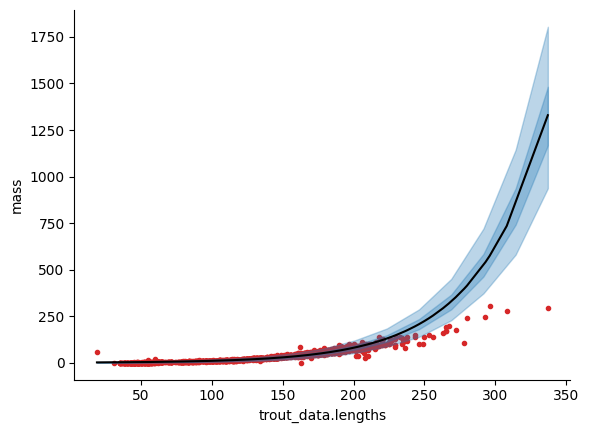

In [61]:
pm.sample_posterior_predictive(idata_trout, model=model_trout,  extend_inferencedata=True)

#grabs the expected line, or line of best fit formula
mean_line = idata_trout.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
lengths = np.random.normal(trout_data.length.values, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

#HDIS
y_pred_q = idata_trout.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and model
_, ax = plt.subplots()
ax.plot(trout_data.length, trout_data.mass, "C3.", zorder=-3)
ax.plot(trout_data.length.to_numpy()[idx], mean_line[idx], c="k")


#graphs HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C0", alpha=0.3)

#labels
ax.set_xlabel("trout_data.lengths")
ax.set_ylabel("mass")

plt.gca().spines[['top', 'right',]].set_visible(False)

Output()

<Axes: xlabel='y_pred'>

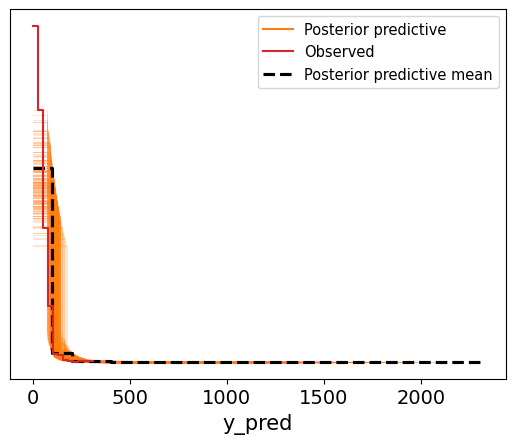

In [62]:
#Show PPC
pm.sample_posterior_predictive(
    idata_trout, model = model_trout, extend_inferencedata=True
    )
az.plot_ppc(idata_trout, num_pp_samples=200, colors=["C1", "C3", "k"])

**This first model seemed "okay." It was fairly accurate for the shorter lengths but got increasingly innacurate at the longer lengths. This still felt like a fine first start.**

**For my next model I thought I would try a new likelihood. I tried a lot of discrete likelihoods, but the only one that ran well was a Poisson distribution.**

In [63]:
with pm.Model() as model_trout:

    #Priors for the linear part
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=20)

    #Covert to deterministic, and exponentiate
    μ = pm.Deterministic("μ", pm.math.exp(α + β * trout_data.length))

    #New Poisson likelihood
    y_pred = pm.Poisson("y_pred", mu=μ, observed=trout_data.mass)

    idata_trout = pm.sample()

Output()

Output()

Output()

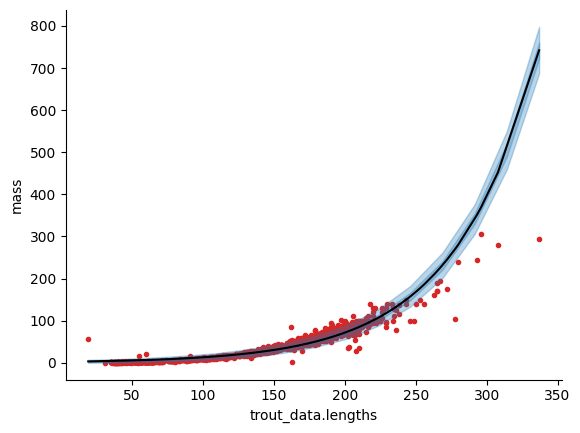

In [64]:
pm.sample_posterior_predictive(idata_trout, model=model_trout,  extend_inferencedata=True)

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_trout.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
lengths = np.random.normal(trout_data.length.values, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_trout.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(trout_data.length, trout_data.mass, "C3.", zorder=-3)
ax.plot(trout_data.length.to_numpy()[idx], mean_line[idx], c="k")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C0", alpha=0.3)

#labels
ax.set_xlabel("trout_data.lengths")
ax.set_ylabel("mass")

plt.gca().spines[['top', 'right',]].set_visible(False)

Output()

<Axes: xlabel='y_pred'>

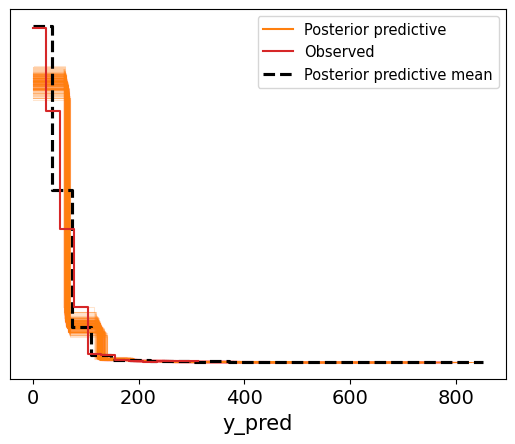

In [65]:
#Show PPC
pm.sample_posterior_predictive(
    idata_trout, model = model_trout, extend_inferencedata=True
    )
az.plot_ppc(idata_trout, num_pp_samples=200, colors=["C1", "C3", "k"])

**Okay! This looked much better, The line followed the data much closer, but still was innacurate near the top end of the data.**

**This is where I was stuck for a while, as all of the discrete distributions did not seem to work well no matter what parameters or priors I set. I started messing around with the model, and what changed my results a lot was instead of exponentialting the whole linear formula, just exponentiating the X axis.**

In [78]:
with pm.Model() as model_trout:

    #Priors for the linear part
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=20)

    #Covert to deterministic and use an exponential line
    μ = pm.Deterministic("μ", α + β * trout_data.length**3)

    #New Poisson likelihood
    y_pred = pm.Poisson("y_pred", mu=μ, observed=trout_data.mass)

    idata_trout = pm.sample()

Output()

Output()

**After trying a few exponent values, 3 (cubic) seemed to work best.**

Output()

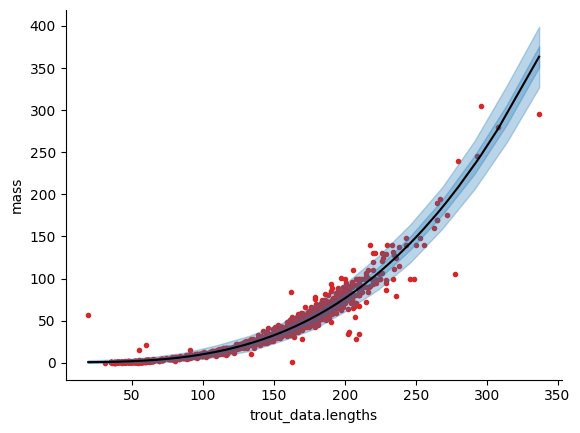

In [79]:
pm.sample_posterior_predictive(idata_trout, model=model_trout,  extend_inferencedata=True)

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_trout.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
lengths = np.random.normal(trout_data.length.values, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_trout.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(trout_data.length, trout_data.mass, "C3.", zorder=-3)
ax.plot(trout_data.length.to_numpy()[idx], mean_line[idx], c="k")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C0", alpha=0.3)

#labels
ax.set_xlabel("trout_data.lengths")
ax.set_ylabel("mass")

plt.gca().spines[['top', 'right',]].set_visible(False)

Output()

<Axes: xlabel='y_pred'>

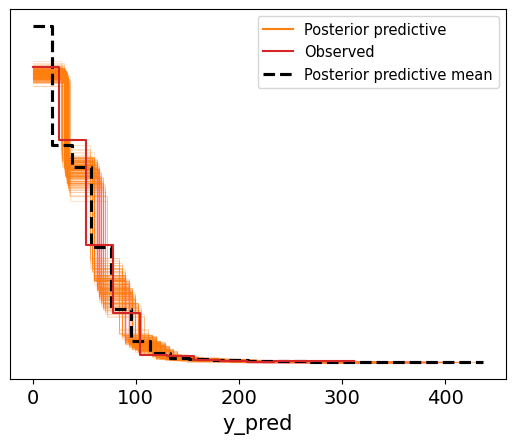

In [68]:
#Show PPC
pm.sample_posterior_predictive(
    idata_trout, model = model_trout, extend_inferencedata=True
    )
az.plot_ppc(idata_trout, num_pp_samples=200, colors=["C1", "C3", "k"])

In [80]:
az.rhat(idata_trout)

<xarray.Dataset> Size: 24kB
Dimensions:  (μ_dim_0: 1490)
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 12kB 0 1 2 3 4 5 ... 1484 1485 1486 1487 1488 1489
Data variables:
    α        float64 8B 1.009
    β        float64 8B 1.003
    μ        (μ_dim_0) float64 12kB 1.0 1.008 1.009 1.009 ... 1.002 1.001 1.001

**This new way to do the exponentiation worked much better. I do not know for sure why the data would be cubic, but I suspect it might have somthing to do with length being one dimensional, and mass being 3 dimensional, almost like the sqaure-sube law. Either way, this worked great! The R-Hat values were good, and the line also looked like it followed the data well, even at the high end.**

**Something I noticed in my last project with this data set was that the different species had different length distributions, so here I separated them to see how they compared.**

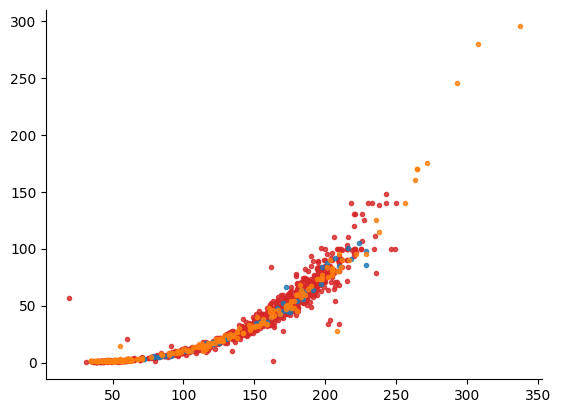

In [74]:
_, ax = plt.subplots()

#Separate species
SalvFont = trout_data.query('scientificName == "Salvelinus fontinalis (Mitchill, 1814)"')
OncoClar = trout_data.query('scientificName == "Oncorhynchus clarkii (Richardson, 1836)"')
SalmTrut = trout_data.query('scientificName == "Salmo trutta (Linnaeus, 1758)"')

#Plot species
ax.plot(SalvFont.length, SalvFont.mass, "C3.", zorder=0, alpha=0.8)
ax.plot(OncoClar.length, OncoClar.mass, "C0.", zorder=1, alpha=0.8)
ax.plot(SalmTrut.length, SalmTrut.mass, "C1.", zorder=2,  alpha=0.8)

#Look cooler
plt.gca().spines[['top', 'right',]].set_visible(False)

**Interestingly, they all followed the same trend but had different domains/ranges. Because of this, I do not think the different species threw off my models accuracy.**